In [1]:
import gym
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import clear_output
from time import sleep

In [2]:
env = gym.make("Taxi-v3").env
env.render()
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))
print('Blue colored letter denotes the pickup location and purple colored letter denotes the drop location.')

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)
Blue colored letter denotes the pickup location and purple colored letter denotes the drop location.


In [3]:
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)
env.s=state
env.render()

State: 328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [4]:
env.P[state]

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

In [4]:
def brute_force(episodes):
    print("Running Brute Force....")
    performance_matrix=[]  
    frames=[]
    for episode in range(episodes):
        clear_output(wait=True)
        print(f"Progress: {(episode/episodes)*100}%")
        state=env.reset()
        epochs, penalties, reward, = 0, 0, 0
        done = False
        while not done:
            action = env.action_space.sample()
            state, reward, done, info = env.step(action)
            if reward == -10:
                penalties += 1
            
            frames.append({
                'episode': episode,
                'frame': env.render(mode='ansi'),
                'state': state,
                'action': action,
                'reward': reward
            })
            epochs += 1
        performance_matrix.append([epochs,penalties])
    return performance_matrix,frames

def q_learning(episodes):
    print("Running Q-Learning...")
    frames = [] 
    performance_matrix=[]
    for episode in range(episodes):
        clear_output(wait=True)
        print(f"Progress: {(episode/episodes)*100}%")
        state = env.reset()
        epochs, penalties, reward = 0, 0, 0
    
        done = False
    
        while not done:
            action = np.argmax(q_table[state])
            state, reward, done, info = env.step(action)

            frames.append({
            'frame': env.render(mode='ansi'),
            'episode':episode,
            'state': state,
            'action': action,
            'reward': reward
            }
            )

            clear_output(wait=True)
            print(env.render(mode='ansi'))
            print(f"Epsiode: {episode}")
            print(f"State: {state}")
            print(f"Action: {action}")
            print(f"Reward: {reward}")
            sleep(.1)

            if reward == -10:
                penalties += 1

            epochs += 1

        performance_matrix.append([epochs,penalties])
    return performance_matrix,frames


def print_frames(frames,sleep_time):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Epsiode: {frame['episode']}")
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(sleep_time)



def plot_performance(title,performance_matrix):
    epochs=[]
    penalties=[]
    for episode_performance in performance_matrix:
        epochs.append(episode_performance[0])
        penalties.append(episode_performance[1])

    df=pd.DataFrame({'episodes': range(0,len(performance_matrix)), 'epochs': epochs, 'penalties': penalties })
    plt.figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    #plt.ylim(top=toplimit)
    plt.plot( 'episodes', 'epochs', data=df, marker='o', markerfacecolor='blue', markersize=1, color='skyblue', linewidth=4)
    plt.plot( 'episodes', 'penalties', data=df, marker='o', markerfacecolor='blue', markersize=1, color='olive', linewidth=4)
    plt.xlabel("Episodes")
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
%%time
#Q-Learning::
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])
#initialize the q-table as a 500 X 6 matrix of zeros as there are 500 states (5*5*5*4) and 6 actions

"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []
q_learning_performance_matrix = []
for i in range(1, 100001):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
    q_learning_performance_matrix.append([epochs,penalties])
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

In [29]:
episodes=100
performance_matrix_b,frames_b=brute_force(episodes)
performance_matrix_q,frames_q=q_learning(episodes)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Epsiode: 19
State: 183
Action: 2
Reward: -1


KeyboardInterrupt: 

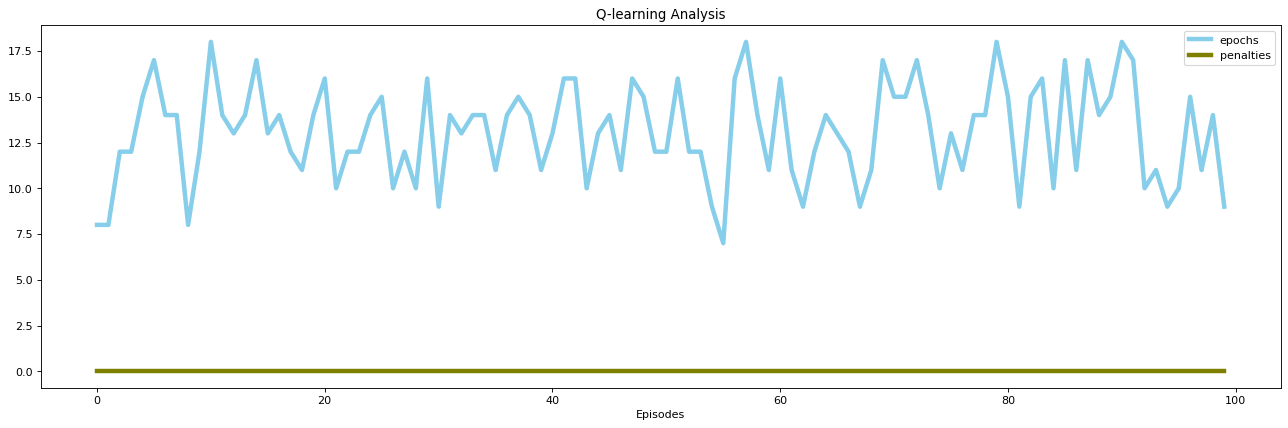

In [10]:
plot_performance("Q-learning Analysis",performance_matrix_q)

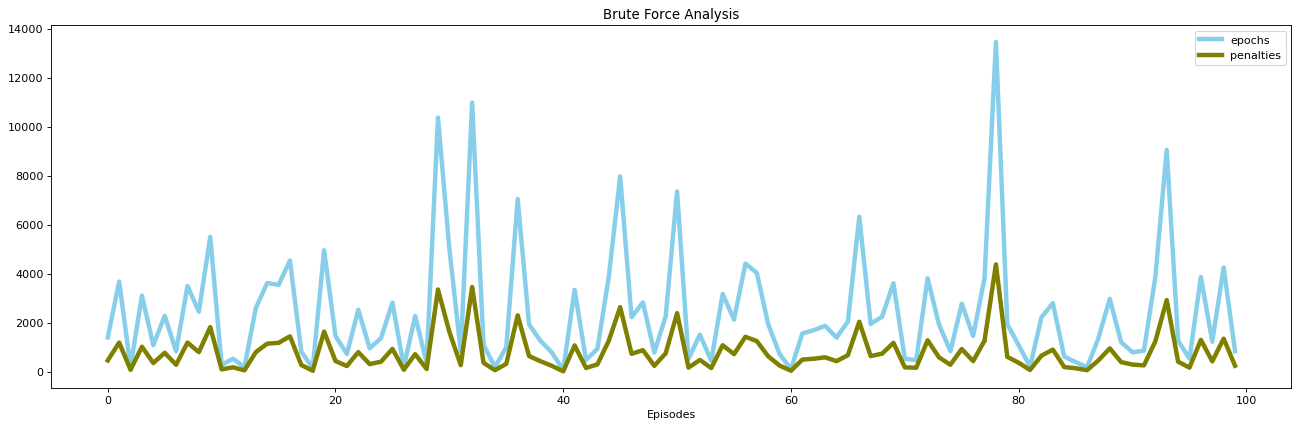

In [11]:
plot_performance("Brute Force Analysis",performance_matrix_b)


In [11]:
print_frames(frames_q,0.2)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

Epsiode: 12
Timestep: 152
State: 66
Action: 2
Reward: -1


KeyboardInterrupt: 

In [ ]:
print_frames(frames_b,0.1)